In [1]:
FN = 'mnist-simple'

This notebook works with Keras version 2

In this notebook we:
* train a on MNIST in which the training labels are scrambled by a fixed permutation 46% of the time
* The baseline 3 layer MLP model gives an accuracy of 74% on MNIST test set which was not scrambled
* The confusion matrix of the noisy training data is computed
* We then add a customized Keras layer ([Channel](./channel.py)) to model the noise. This layer is initialized with the log of the confusion matrix (`channel_weights`):
```python
channeled_output = Channel(name='channel',weights=[channel_weights])(baseline_output)
```
* We continue training on the new output (`channeled_output`)
* The baseline output (`baseline_output`) has now an accuracy of 98%.

For more information see the description of the [simple noise adaptation layer in the paper](https://openreview.net/forum?id=H12GRgcxg)

In [2]:
from __future__ import print_function
import numpy as np
import random
seed = 42
np.random.seed(seed)  # for reproducibility
random.seed(seed)
verbose = True

In [3]:
# in case you dont have a GPU
import os
os.environ['THEANO_FLAGS'] = 'device=cpu,floatX=float32'  # Use CPU on Theano
os.environ['CUDA_VISIBLE_DEVICES'] = ''  # Disable GPU usage on tensorflow

# Data

In [4]:
nb_classes = 10 # number of categories we classify. MNIST is 10 digits
# input image dimensions. In CNN we think we have a "color" image with 1 channel of color.
# in MLP with flatten the pixels to img_rows*img_cols
img_color, img_rows, img_cols = 1, 28, 28
img_size = img_color*img_rows*img_cols

In [5]:
from keras.datasets import mnist
# keras has a built in tool that download the MNIST data set for you to `~/.keras/datasets/`
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print('MNIST training data set label distribution', np.bincount(y_train))
print('test distribution', np.bincount(y_test))

Using Theano backend.


MNIST training data set label distribution [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]
test distribution [ 980 1135 1032 1010  982  892  958 1028  974 1009]


In [6]:
X_train = X_train.reshape(X_train.shape[0], img_size)
X_test = X_test.reshape(X_test.shape[0], img_size)
    
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.
X_test /= 255.
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 784)
60000 train samples
10000 test samples


## noisy labels

In [7]:
NOISE_LEVEL=0.46  # what part of training labels are permuted
perm = np.array([7, 9, 0, 4, 2, 1, 3, 5, 6, 8])  # noise permutation (from Reed)

In [8]:
noise = perm[y_train]

In [9]:
# replace some of the training labels with permuted (noise) labels.
# make sure each categories receive an equal amount of noise
from sklearn.model_selection import StratifiedShuffleSplit
_, noise_idx = next(iter(StratifiedShuffleSplit(n_splits=1,
                                                test_size=NOISE_LEVEL,
                                                random_state=seed).split(X_train,y_train)))
y_train_noise = y_train.copy()
y_train_noise[noise_idx] = noise[noise_idx]

actual noise level

In [10]:
1. - np.mean(y_train_noise == y_train)

0.45999999999999996

split training data to training and validation

In [11]:
# break the training set to 10% validation which we will use for early stopping.
train_idx, val_idx = next(iter(
        StratifiedShuffleSplit(n_splits=1, test_size=0.1,
                               random_state=seed).split(X_train, y_train_noise)))
X_train_train = X_train[train_idx]
y_train_train = y_train_noise[train_idx]
X_train_val = X_train[val_idx]
y_train_val = y_train_noise[val_idx]

# Model

## baseline model
We use the `Sequential` model from keras
[mlp example](https://github.com/fchollet/keras/blob/master/examples/mnist_mlp.py)
as a single layer which computes the last hidden layer which we then use to
compute the baseline and as an input to the channel matrix

In [12]:
nhiddens = [500, 300]
DROPOUT=0.5
opt='adam'
batch_size = 256
patience = 4  # Early stopping patience
epochs = 40  # number of epochs to train on

In [13]:
from keras.models import Sequential
hidden_layers = Sequential(name='hidden')

In [14]:
from keras.layers import Dense, Dropout, Activation
for i, nhidden in enumerate(nhiddens):
    hidden_layers.add(Dense(nhidden,
                            input_shape=(img_size,) if i == 0 else []))
    hidden_layers.add(Activation('relu'))
    hidden_layers.add(Dropout(DROPOUT))

In [15]:
from keras.layers import Input
train_inputs = Input(shape=(img_size,))

In [16]:
last_hidden = hidden_layers(train_inputs)
baseline_output = Dense(nb_classes, activation='softmax', name='baseline')(last_hidden)

In [17]:
from keras.models import Model
model = Model(inputs=train_inputs, outputs=baseline_output)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

baseline model performance evaluation before training

In [18]:
def eval(model,y_test=y_test):
    return dict(zip(model.metrics_names,model.evaluate(X_test,y_test, verbose=False)))

In [19]:
eval(model)

{'acc': 0.090800000000000006, 'loss': 2.3604063068389891}

### baseline training

In [20]:
from keras.callbacks import EarlyStopping
train_res = model.fit(X_train_train,
                      y_train_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=verbose,
                      validation_data=(X_train_val,
                                       y_train_val),
                      callbacks=
                      [EarlyStopping(patience=patience,mode='min',
                                     verbose=verbose)]
                      )

Train on 54000 samples, validate on 6000 samples
Epoch 1/40
54000/54000 [==============================] - 5s - loss: 1.2561 - acc: 0.4230 - val_loss: 0.9025 - val_acc: 0.4867
Epoch 2/40
54000/54000 [==============================] - 5s - loss: 0.9392 - acc: 0.4828 - val_loss: 0.8409 - val_acc: 0.4802
Epoch 3/40
54000/54000 [==============================] - 5s - loss: 0.8770 - acc: 0.4946 - val_loss: 0.8118 - val_acc: 0.4882
Epoch 4/40
54000/54000 [==============================] - 5s - loss: 0.8451 - acc: 0.5004 - val_loss: 0.7988 - val_acc: 0.4955
Epoch 5/40
54000/54000 [==============================] - 5s - loss: 0.8223 - acc: 0.5076 - val_loss: 0.7839 - val_acc: 0.5108
Epoch 6/40
54000/54000 [==============================] - 7s - loss: 0.8083 - acc: 0.5104 - val_loss: 0.7804 - val_acc: 0.5142
Epoch 7/40
54000/54000 [==============================] - 6s - loss: 0.7934 - acc: 0.5117 - val_loss: 0.7715 - val_acc: 0.5088
Epoch 8/40
54000/54000 [==============================] - 6s -

### baseline performance

In [21]:
eval(model)

{'acc': 0.74380000000000002, 'loss': 0.68568477287292484}

In [22]:
# build confusion matrix (prediction,noisy_label)
ybaseline_predict = model.predict(X_train,batch_size=batch_size)

In [23]:
ybaseline_predict = np.argmax(ybaseline_predict, axis=-1)
ybaseline_predict.shape

(60000,)

In [24]:
baseline_confusion = np.zeros((nb_classes, nb_classes))
for n, p in zip(y_train_noise, ybaseline_predict):
    baseline_confusion[p, n] += 1.

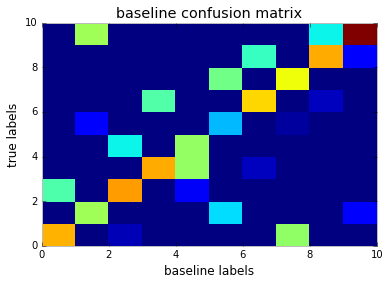

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
# perm_bias_weights.astype(int)
plt.pcolor(baseline_confusion)
plt.ylabel('true labels')
plt.xlabel('baseline labels')
plt.title('baseline confusion matrix');

## Simple channel model

In [26]:
# ignore baseline loss in training
BETA = 0.

In [27]:
channel_weights = baseline_confusion.copy()
channel_weights /= channel_weights.sum(axis=1, keepdims=True)
# perm_bias_weights[prediction,noisy_label] = log(P(noisy_label|prediction))
channel_weights = np.log(channel_weights + 1e-8)

In [28]:
# If you dont have a pre-trained baseline model then use this
# channel_weights = (
#     np.array([[np.log(1. - NOISE_LEVEL)
#                         if i == j else
#                         np.log(NOISE / (nb_classes - 1.))
#                         for j in range(nb_classes)] for i in
#               range(nb_classes)])
#     + 0.01 * np.random.random((nb_classes, nb_classes)))

In [29]:
from channel import Channel
channeled_output = Channel(name='channel',weights=[channel_weights])(baseline_output)

In [30]:
simple_model = Model(inputs=train_inputs, outputs=[channeled_output, baseline_output])
simple_model.compile(loss='sparse_categorical_crossentropy',loss_weights=[1.-BETA, BETA],
              optimizer=opt,
              metrics=['accuracy'])

In [31]:
train_res = simple_model.fit(X_train_train,
                      [y_train_train,y_train_train],
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=verbose,
                      validation_data=(X_train_val,
                                       [y_train_val,y_train_val]),
                      callbacks=
                      [EarlyStopping(patience=patience,mode='min',verbose=verbose)]
                      )

Train on 54000 samples, validate on 6000 samples
Epoch 1/40
54000/54000 [==============================] - 5s - loss: 0.8482 - channel_loss: 0.8482 - baseline_loss: 1.8758 - channel_acc: 0.5312 - baseline_acc: 0.5292 - val_loss: 0.8508 - val_channel_loss: 0.8508 - val_baseline_loss: 2.1850 - val_channel_acc: 0.5222 - val_baseline_acc: 0.5188
Epoch 2/40
54000/54000 [==============================] - 5s - loss: 0.8203 - channel_loss: 0.8203 - baseline_loss: 2.4552 - channel_acc: 0.5360 - baseline_acc: 0.5316 - val_loss: 0.8354 - val_channel_loss: 0.8354 - val_baseline_loss: 2.6793 - val_channel_acc: 0.5283 - val_baseline_acc: 0.5233
Epoch 3/40
54000/54000 [==============================] - 5s - loss: 0.8058 - channel_loss: 0.8058 - baseline_loss: 2.7526 - channel_acc: 0.5371 - baseline_acc: 0.5324 - val_loss: 0.8192 - val_channel_loss: 0.8192 - val_baseline_loss: 2.8539 - val_channel_acc: 0.5193 - val_baseline_acc: 0.5217
Epoch 4/40
54000/54000 [==============================] - 6s - los

In [32]:
eval(simple_model,y_test=[y_test,y_test])

{'baseline_acc': 0.92569999999999997,
 'baseline_loss': 0.24902633275985717,
 'channel_acc': 0.94979999999999998,
 'channel_loss': 0.67406886959075929,
 'loss': 0.67406886959075929}